# Assessing Ocean Circulation, Carbon Uptake, and Environmental Changes

*How does the ocean’s circulation connect to carbon storage and environmental shifts?*

This notebook can be run with Binder by following the link:
[polarin_bottles](https://mybinder.org/v2/gh/POLAR-RESEARCH-INFRASTRUCTURE-NETWORK/jupyter-notebooks/HEAD?urlpath=%2Fdoc%2Ftree%2Fdata_cookbook%2Fpolarin_bottles.ipynb)

The purpose of this notebook is to show the use of in situ observations as bottle data to assess ocean circulation, carbon uptake and environemntal changes.

The tool uses the following product:

- POLARIN's ERDDAP's dataset (https://erddap.s4polarin.eu/erddap/tabledap/cnr_iadc_9c61_fff7_d03c.html)

The first code cell installs and imports into the notebook all the necessary libraries to run the code of the subsequent cells. The second one retrieves a list of platforms from the dataset, filtering them by latitude to include only those with latitude less than -55 or latitude greater than 55. A dropdown menu is created to allow the user to select a platform from this list. Upon selection, the code fetches the corresponding trajectory data and updates a plot to visualize the platform's trajectory based on latitude and longitude coordinates. It will also store in the notebook's memory some functions that will be used later.

In [ ]:
# @title
!pip install cartopy scipy seaborn
from ipywidgets import Dropdown, Layout, HBox, VBox, Output
from scipy.stats import linregress
from io import BytesIO
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# @title
BASE_URL_DATASET = 'https://erddap.s4polarin.eu/erddap/tabledap/cnr_iadc_9c61_fff7_d03c'

north_lat_limit = 55
south_lat_limit = -55

coords_padding = 10

def get_platforms():
    profile_ids_query_north = f'.csvp?Bottle_No&latitude%3E={north_lat_limit}&distinct()'
    profile_ids_query_south = f'.csvp?Bottle_No&latitude%3C={south_lat_limit}&distinct()'

    resp_north = requests.get(BASE_URL_DATASET + profile_ids_query_north)
    df_north = pd.read_csv(BytesIO(resp_north.content), encoding='utf-8', dtype=str)

    resp_south = requests.get(BASE_URL_DATASET + profile_ids_query_south)

    df_south = pd.read_csv(BytesIO(resp_south.content), encoding='utf-8', dtype=str)

    frames = [df_north, df_south]
    df_platforms = pd.concat(frames)

    platforms = list(df_platforms['Bottle_No'])
    return platforms, df_platforms

def var_name_uom_map():
    metadata_url = 'https://erddap.s4polarin.eu/erddap/info/cnr_iadc_9c61_fff7_d03c/index.csv'
    resp_metadata = requests.get(metadata_url)
    df_metadata = pd.read_csv(BytesIO(resp_metadata.content), header=0, encoding='utf-8')

    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('_error', na=False)]
    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('_qc', na=False)]
    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('_unk', na=False)]
    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('_68', na=False)]
    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('ref_', na=False)]
    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('rev_', na=False)]
    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('bottle_', na=False)]
    df_metadata.reset_index(drop=True, inplace=True)

    variable_long_name_map = {}
    variable_units_map = {}

    current_variable = None
    for index, row in df_metadata.iterrows():
        if row['Row Type'] == 'variable':
            current_variable = row['Variable Name']
            variable_long_name_map[current_variable] = current_variable
            variable_units_map[current_variable] = ''

        elif row['Row Type'] == 'attribute' and current_variable:
            if row['Attribute Name'] == 'long_name':
                variable_long_name_map[current_variable] = row['Value'].encode('utf-8').decode('unicode_escape')
            elif row['Attribute Name'] == 'units':
                unit = row['Value'] if row['Value'] != 'Unknown' else ''
                unit = unit.encode('utf-8').decode('unicode_escape')
                variable_units_map[current_variable] = unit

    variable_units_map['time'] = ''
    variable_units_map['ctd_salinity'] = 'psu'

    return variable_long_name_map, variable_units_map

def get_filtered_variable_map(selected_platform, variable_long_name_map, non_valid_vars=None, additional_vars=None):
    data_query = f'.csv?&Bottle_No={selected_platform}'
    resp = requests.get(BASE_URL_DATASET + data_query)
    df = pd.read_csv(BytesIO(resp.content), header=0, encoding='utf-8')
    df = df.iloc[1:]

    df.dropna(axis=1, how='all', inplace=True)
    df.dropna(axis=0, how='all', inplace=True)

    all_vars = list(df.columns)

    filtered_variable_long_name_map = {k: v for k, v in variable_long_name_map.items() if k in all_vars}

    if additional_vars:
        filtered_variable_long_name_map.update(additional_vars)

    for non_valid_var in non_valid_vars:
        filtered_variable_long_name_map.pop(non_valid_var, None)

    long_name_to_variable_map = {v: k for k, v in filtered_variable_long_name_map.items()}

    return filtered_variable_long_name_map, long_name_to_variable_map

platforms, df_platforms = get_platforms()

selected_platform = platforms[0]

dropdown_platforms = Dropdown(
    options=platforms,
    value=platforms[0],
    description='Select a platform:',
    layout=Layout(width='300px'),
    style={'description_width': 'initial'}
)

output_plot = Output()

def update_plot():
    with output_plot:
        output_plot.clear_output(wait=True)
        data_query = f'.csv?time%2Clatitude%2Clongitude&Bottle_No={selected_platform}'
        resp = requests.get(BASE_URL_DATASET + data_query)
        df = pd.read_csv(BytesIO(resp.content), header=0, encoding='utf-8')
        if df.empty:
            print("No data available for the selected platform.")
            return

        df = df.iloc[1:]
        df['latitude'] = df['latitude'].astype(float)
        df['longitude'] = df['longitude'].astype(float)

        min_lat, mean_lat, max_lat = df['latitude'].min(), df['latitude'].mean(), df['latitude'].max()
        min_lon, mean_lon, max_lon = df['longitude'].min(), df['longitude'].mean(), df['longitude'].max()

        lat_range = max_lat - min_lat
        lon_range = max_lon - min_lon
        max_range = max(lat_range, lon_range)

        lat_buffer = (max_range - lat_range) / 2 + coords_padding
        lon_buffer = (max_range - lon_range) / 2 + coords_padding

        projection = ccrs.PlateCarree()

        fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': projection})

        ax.add_feature(cfeature.LAND, edgecolor='black')
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        ax.plot(df['longitude'], df['latitude'], marker='.', linestyle='-', color='lime', transform=ccrs.PlateCarree())
        ax.set_title(f'Trajectory for Platform: {selected_platform}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

        ax.set_xticks([min_lon - lon_buffer, mean_lon, max_lon + lon_buffer])
        ax.set_yticks([min_lat - lat_buffer, mean_lat, max_lat + lat_buffer])

        ax.set_xlim(min_lon - lon_buffer, max_lon + lon_buffer)
        ax.set_ylim(max(min_lat - lat_buffer, -90), min(max_lat + lat_buffer, 90))

        plt.show()

def on_change(change):
    global selected_platform
    if dropdown_platforms.value:
        selected_platform = dropdown_platforms.value
        update_plot()

dropdown_platforms.observe(on_change, names='value')

hbox = VBox([dropdown_platforms, output_plot])

display(hbox)

update_plot()

## Visualize the correlation between two parameters for the selected platform

This code cell initializes and displays dropdown menus that allow the user to select variables, between all the ones available for the selected platform, for the X and Y axes of a scatter plot, as well as choose between linear and logarithmic scales for each. The selected variables and scales will be stored globally, and the plot will update according to the chosen values.

In [ ]:
# @title
variable_long_name_map, units_map = var_name_uom_map()
non_valid_vars = ['time', 'latitude', 'longitude', 'Project', 'Cruise', 'Station', 'Type', 'line_id', 'Bottle N\u00b0', 'sample', 'BottleNo', 'profile_type']
filtered_variable_long_name_map, long_name_to_variable_map = get_filtered_variable_map(selected_platform, variable_long_name_map, non_valid_vars=non_valid_vars)

first_var = 'Pressure'
second_var = 'time'

x_scale = 'Linear'
y_scale = 'Linear'

dropdown_1 = Dropdown(
    options=list(long_name_to_variable_map.keys()),
    value='Bot. Depth [m]',
    description='Y axis variable:',
    layout=Layout(width='300px'),
    style={'description_width': 'initial'}
)

dropdown_2 = Dropdown(
    options=list(long_name_to_variable_map.keys()),
    value='T90 [°C]',
    description='X axis variable:',
    layout=Layout(width='300px'),
    style={'description_width': 'initial'}
)

x_scale_dropdown = Dropdown(
    options=['Linear', 'Logarithmic'],
    value='Linear',
    description='Choose the scale:',
    layout=Layout(width='300px'),
    style={'description_width': 'initial'}
)

y_scale_dropdown = Dropdown(
    options=['Linear', 'Logarithmic'],
    value='Linear',
    description='Choose the scale:',
    layout=Layout(width='300px'),
    style={'description_width': 'initial'}
)

def on_change(change):
    global first_var
    global second_var
    global x_scale
    global y_scale
    if dropdown_1.value and dropdown_2.value and x_scale_dropdown.value and y_scale_dropdown.value:
        first_var = long_name_to_variable_map[dropdown_1.value]
        second_var = long_name_to_variable_map[dropdown_2.value]

        y_scale = y_scale_dropdown.value
        x_scale = x_scale_dropdown.value

dropdown_1.observe(on_change, names='value')
dropdown_2.observe(on_change, names='value')

x_scale_dropdown.observe(on_change, names='value')
y_scale_dropdown.observe(on_change, names='value')

vbox_1 = VBox([dropdown_1, dropdown_2])
vbox_2 = VBox([y_scale_dropdown, x_scale_dropdown])

hbox = HBox([vbox_1, vbox_2])
display(hbox)

on_change(None)

Once the variables and scales have been selected, the next code cell generates a scatter plot to visualize the correlation between them. It fetches the data from the server, filters, and sorts it based on the chosen variables. It colors the data points by time, creating a color-coded legend for profile times. The plot will automatically adjust to these settings for accurate analysis.

In this plot, a linear regression is also applied to show the relationship between the two selected variables. Linear regression is a statistical method used to model the relationship between two variables by fitting a straight line through the data. The line represents the best estimate of how one variable  changes in response to the other variable. Below the plot the R-squared and p-value obtained from the linear regression will be shown.

- R-squared (R²): This value represents how well the regression line fits the data. It ranges from 0 to 1, where 1 means a perfect fit. A higher R² means that the line explains a larger portion of the variance in the data.

- P-value: This tells us whether the relationship between the variables is statistically significant. A small p-value (typically less than 0.05) suggests that the correlation is likely not due to chance, implying a strong association between the variables.

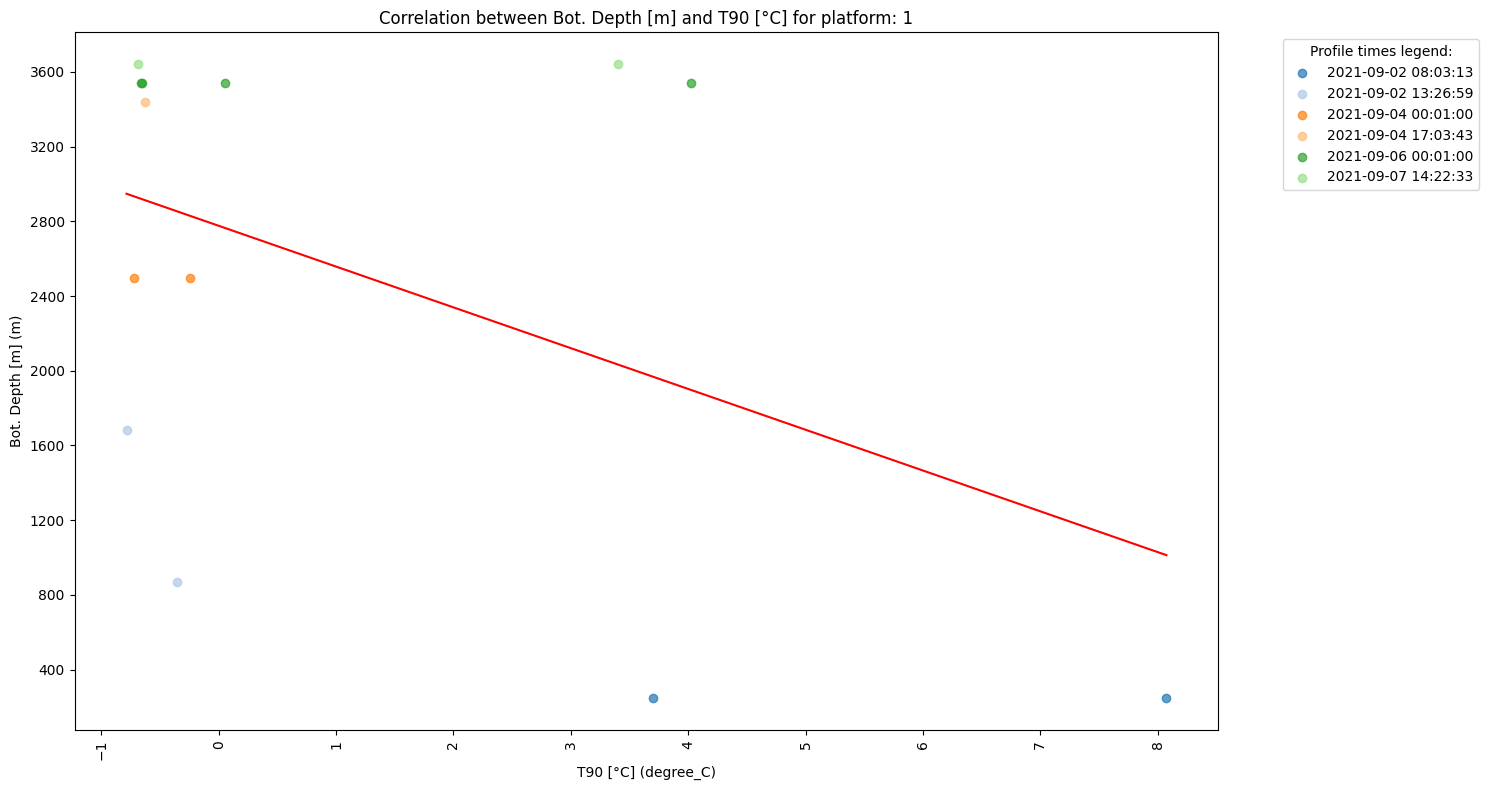

Linear Regression:
R² = 0.21
P-value = 0.11590559344129535


In [ ]:
# @title
if first_var != 'time' and second_var != 'time':
    if first_var == second_var:
        data_query = f'.csv?time%2C{first_var}%2CStation&Bottle_No={selected_platform}'
    else:
        data_query = f'.csv?time%2C{first_var}%2C{second_var}%2CStation&Bottle_No={selected_platform}'
else:
    if first_var == second_var:
        data_query = f'.csv?{first_var}%2CStation&Bottle_No={selected_platform}'
    else:
        data_query = f'.csv?{first_var}%2C{second_var}%2CStation&Bottle_No={selected_platform}'

resp = requests.get(BASE_URL_DATASET + data_query)
df = pd.read_csv(BytesIO(resp.content), header=0, encoding='utf-8')

df = df.iloc[1:]

df[first_var] = pd.to_numeric(df[first_var], errors='coerce')
df[second_var] = pd.to_numeric(df[second_var], errors='coerce')

df = df.dropna(subset=[first_var, second_var])
df = df.sort_values(by=[second_var, first_var])

time_values = sorted(df['time'].unique())
palette = sns.color_palette("tab20", len(time_values))
profile_colors = dict(zip(time_values, palette))

plt.figure(figsize=(15, 8))

for t in time_values:
    mask = df['time'] == t
    plt.scatter(
        df.loc[mask, second_var],
        df.loc[mask, first_var],
        color=profile_colors[t],
        label=t.replace('T', ' ').replace('Z', ''),
        alpha=0.7
    )

if len(df) > 0:
    slope, intercept, r_value, p_value, std_err = linregress(df[second_var], df[first_var])
    x_range = np.linspace(df[second_var].min(), df[second_var].max(), 100)
    regression_line = slope * x_range + intercept

    plt.plot(x_range, regression_line, color='red')

plt.ylabel(filtered_variable_long_name_map[first_var] + ' (' + units_map[first_var] + ')' if units_map[first_var] else filtered_variable_long_name_map[first_var])
plt.xlabel(filtered_variable_long_name_map[second_var] + ' (' + units_map[second_var] + ')' if units_map[second_var] else filtered_variable_long_name_map[second_var])

ax = plt.gca()
ax.set_title(f'Correlation between {filtered_variable_long_name_map[first_var]} and {filtered_variable_long_name_map[second_var]} for platform: {selected_platform}')

ax.set_xscale('log' if x_scale == 'Logarithmic' else 'linear')
ax.set_yscale('log' if y_scale == 'Logarithmic' else 'linear')

if x_scale == 'Logarithmic':
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0))

if y_scale == 'Logarithmic':
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0))

ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=False, prune='lower'))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=False, prune='lower'))

plt.legend(title='Profile times legend:', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print(f'Linear Regression:\nR² = {r_value**2:.2f}\nP-value = {p_value}')

### **Additional resources**

The Python libraries that have been used in this notebook are:
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/)
- [scipy](https://scipy.org/)
- [requests](https://requests.readthedocs.io/en/latest/)
- [seaborn](https://seaborn.pydata.org/)
- [numpy](https://numpy.org/)
- [pandas](https://pandas.pydata.org/)
- [matplotlib](https://matplotlib.org/)

This work has received funding from the European Union Horizon Europe project Polar Research Infrastructure Network (POLARIN) under grant agreement No. 101130949 (https://doi.org/10.3030/101130949).
This notebook makes use of data available in the European Marine Observation and Data Network (EMODnet, https://emodnet.ec.europa.eu).

| | | |
|:-:|:-:|:-:|
| <img src="https://ocean-ice.eu/wp-content/uploads/2025/02/TO-USE-RGB-for-digital-materials-V.png" width="160"/> | <img src="https://eu-polarin.eu/wp-content/uploads/2024/04/polarin-web1.svg" width="140"/> | <img src="https://emodnet.ec.europa.eu/sites/emodnet.ec.europa.eu/files/public/emodnet_logos/web/EMODnet_standard_colour.png" width="140"/> |

